# Problem 1 - Object Localization

First, switch to GPU.

In this problem, we will implement a network for a single object detection task. The dataset we will use is The Oxford-IIIT Pet Dataset, which also includes corresponding bounding boxes. Our task will be to predict what animal is in the image and at the same time draw a bounding box around the animal - solving multiple tasks simultaneously is called multi-task learning.

1. Explain what function ```parse()``` is doing

2. Compute the output of the EfficientNet and use it to
*  Predict parameters of bounding box ```x```: use convolution with 4 filters of size $3\times 3$ followed by global average pooling.
*  Predict class ```y```: Use global average pooling, dropout with rate 0.2 and fully connected layer with suitable activation function. You have to use the activation.

3. Define a callback for decreasing the learning rate. It should decrease LR by a factor of 5 whenever the validation intersection over union (```val_iou``` returned by validation callback) doesn't increase in 3 epochs. The LR shouldn't go below $10^{-7}$. (Hint: you don't have to define a new callback class). Train the network for 25 epochs.

4. For 9 images in validation set show:
*  The image
*  true bounding box as a blue rectangle
*  predicted bounding box as a red rectangle
*  true and predicted class

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import glob
import cv2
import csv
import xml.etree.ElementTree as ET
import os
import PIL
!pip install --quiet -U git+https://github.com/qubvel/efficientnet
!pip install --quiet -U git+https://github.com/albumentations-team/albumentations
import efficientnet.keras as efn 
import albumentations as A


     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 952kB 6.2MB/s 


In [ ]:
# download the dataset
dataset_url = 'http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz'
!gdown {dataset_url}
!tar xf images.tar.gz
!rm images.tar.gz

Downloading...
From: http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
To: /content/images.tar.gz
100% 792M/792M [00:35<00:00, 22.1MB/s]


In [ ]:
# download training and validation annotation files - train.csv, val.csv
url = 'https://drive.google.com/uc?id=1LpepGmaXc1tIsN99PRN3LYFtBbRYZHSz'
!gdown {url}
url = 'https://drive.google.com/uc?id=1hDYnv6F1tNJ2U4caDNpjKOw_bzZ98aoG'
!gdown {url}

Downloading...
From: https://drive.google.com/uc?id=1LpepGmaXc1tIsN99PRN3LYFtBbRYZHSz
To: /content/train.csv
100% 205k/205k [00:00<00:00, 62.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hDYnv6F1tNJ2U4caDNpjKOw_bzZ98aoG
To: /content/val.csv
100% 48.2k/48.2k [00:00<00:00, 39.1MB/s]


In [ ]:
IMAGE_SIZE = 160
EPOCHS = 25
BATCH_SIZE = 32
CLASSES = 37
DATA_FOLDER = './images/'
TRAIN_CSV = 'train.csv'
VAL_CSV = 'val.csv'
TRN_SIZE = 2984
VAL_SIZE = 702

In [ ]:
transforms_train = A.Compose([
            A.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1),
            A.GaussNoise(p=0.1),
            A.HorizontalFlip(p=0.5),
            A.RandomRotate90(p=1.0),
            A.ToGray(p=0.2),
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

transforms_val = A.Compose([
            A.Resize(IMAGE_SIZE, IMAGE_SIZE, p=1)
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

def aug_fn(image, bbox, label, train):
    data = {"image": image, "bboxes": [bbox], "class_labels":[label]}
    if train:
      data = transforms_train(**data)
    else:
      data = transforms_val(**data)
    aug_img = data["image"]
    aug_bbox = tf.squeeze(data["bboxes"])
    aug_label = data["class_labels"]
    aug_img = efn.preprocess_input(aug_img) # Don't forget the preprocess function!
    return aug_img, tf.cast(tf.concat([aug_bbox, aug_label], axis=-1), tf.float32)

def parse(imdata):
  image = tf.io.read_file(imdata['path'])
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.cast(image, tf.float32)
  box_x0 = imdata['box_x0']
  box_y0 = imdata['box_y0']
  box_x1 = imdata['box_x1']
  box_y1 = imdata['box_y1']
  label = imdata['class_id']
  return image, [box_x0, box_y0, box_x1, box_y1], label

def process_data_train(image, bbox, label):
    aug_img, aug_target = tf.numpy_function(func=aug_fn, inp=[image, bbox, label, True], 
                                Tout=[tf.float32, tf.float32])
    return aug_img, aug_target

def process_data_val(image, bbox, label):
    aug_img, aug_target = tf.numpy_function(func=aug_fn, inp=[image, bbox, label, False], 
                                Tout=[tf.float32, tf.float32])
    return aug_img, aug_target

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = tf.data.experimental.make_csv_dataset(TRAIN_CSV, 
                batch_size=1).unbatch()
train_ds = train_ds.map(parse, num_parallel_calls=AUTOTUNE).map(process_data_train,
                        num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

val_ds = tf.data.experimental.make_csv_dataset(VAL_CSV, 
                batch_size=1, num_epochs=1).unbatch()
val_ds = val_ds.map(parse, num_parallel_calls=AUTOTUNE).map(process_data_val,
                        num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

 1. Explain what function parse is doing
The function parse is used to get the label of the images. the label contains the bounding box coordinates and the classes of the images. Also, this function returns the image itself, given the path.
Information such as the path of the image, the bounding box data, and the class id is obtain from the .csv files. Then it is pass into the parse function to obtain the image and its label



In [ ]:
class Validation(tf.keras.callbacks.Callback):
  def __init__(self, dataset):
      self.dataset = dataset

  def on_epoch_end(self, epoch, logs):
    mse = 0
    accuracy = 0

    intersections = 0
    unions = 0

    for batch_images, label in iter(self.dataset):
      true_box, class_id = label[:,:4], label[:,-1]
      pred_box, pred_class = self.model.predict_on_batch(batch_images)
      mse += np.linalg.norm(true_box - pred_box, ord='fro') / pred_box.shape[0]

      pred_class = np.argmax(pred_class, axis=1)
      accuracy += np.sum(class_id == pred_class)

      pred_box = np.maximum(pred_box, 0)

      diff_width = np.minimum(true_box[:,0] + true_box[:,2], pred_box[:,0] + pred_box[:,2]) - np.maximum(true_box[:,0], pred_box[:,0])
      diff_height = np.minimum(true_box[:,1] + true_box[:,3], pred_box[:,1] + pred_box[:,3]) - np.maximum(true_box[:,1], pred_box[:,1])
      intersection = np.maximum(diff_width, 0) * np.maximum(diff_height, 0)

      area_true_box = true_box[:,2] * true_box[:,3]
      area_pred_box = pred_box[:,2] * pred_box[:,3]
      union = np.maximum(area_true_box + area_pred_box - intersection, 0)

      intersections += np.sum(intersection * (union > 0))
      unions += np.sum(union)

    iou = np.round(intersections / (unions + tf.keras.backend.epsilon()), 4)
    logs["val_iou"] = iou

    mse = np.round(mse, 4)
    logs["val_mse"] = mse

    accuracy = np.round(accuracy / VAL_SIZE, 4)
    logs["val_acc"] = accuracy

    print(" - val_iou: {} - val_mse: {} - val_acc: {}".format(iou, mse, accuracy))

In [ ]:
def log_mse(y_true, y_pred_box):
  y_true_box = y_true[:,:4]
  return tf.reduce_mean(tf.math.log1p(tf.math.squared_difference(y_pred_box, y_true_box)), axis=-1)

In [ ]:
def focal_loss(gamma=2., alpha=4.):
  gamma = float(gamma)
  alpha = float(alpha)

  def focal_loss_fixed(y_true, y_pred):
    """Focal loss for multi-classification
    FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
    Notice: y_pred is probability after softmax
    gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
    d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
    Focal Loss for Dense Object Detection
    https://arxiv.org/abs/1708.02002
    """
    epsilon = 1.e-9
    y_true_class = tf.one_hot(tf.cast(y_true[:,-1], tf.uint8), CLASSES)
    y_pred_class = tf.convert_to_tensor(y_pred, tf.float32)

    model_out = tf.add(y_pred_class, epsilon)
    ce = tf.multiply(y_true_class, -tf.math.log(model_out))
    weight = tf.multiply(y_true_class, tf.pow(tf.subtract(1., model_out), gamma))
    fl = tf.multiply(alpha, tf.multiply(weight, ce))
    reduced_fl = tf.reduce_max(fl, axis=1)
    return tf.reduce_mean(reduced_fl)
  return focal_loss_fixed

# 2. 

def create_model():
  base_model = efn.EfficientNetB0(weights='imagenet', include_top=False)
  inputs = tf.keras.Input(shape = (IMAGE_SIZE,IMAGE_SIZE,3))
  x = base_model(inputs)
  x = tf.keras.layers.Conv2D(filters = 4, kernel_size = (3,3))(x)
  x = tf.keras.layers.GlobalAveragePooling2D(name= 'box_coords')(x)
  y = base_model(inputs)
  y = tf.keras.layers.GlobalAveragePooling2D()(y)
  y = tf.keras.layers.Dropout(0.2)(y)  
  y = tf.keras.layers.Dense(CLASSES,activation='relu', name = 'classes')(y)


  return tf.keras.Model(inputs=inputs, outputs=[x, y])

In [ ]:
# 2. 

def create_model():
  base_model = efn.EfficientNetB0(weights='imagenet', include_top=False)
  inputs = tf.keras.Input(shape = (IMAGE_SIZE,IMAGE_SIZE,3))
  input = base_model(inputs)

  x = tf.keras.layers.Conv2D(filters = 4, kernel_size = (3,3))(input) # change t0 3 instead of (3,3)
  x = tf.keras.layers.GlobalAveragePooling2D(name= 'box_coords')(x)
  
  y = tf.keras.layers.GlobalAveragePooling2D()(input)
  y = tf.keras.layers.Dropout(0.2)(y)  
  y = tf.keras.layers.Dense(CLASSES,activation='softmax', name = 'classes')(y)


  return tf.keras.Model(inputs=inputs, outputs=[x, y])

In [ ]:
model = create_model()

16809984/16804768 [==============================] - 1s 0us/step


In [ ]:
optimizer = tf.keras.optimizers.Adam()
model.compile(loss={'box_coords' : log_mse, 'classes' : focal_loss()}, 
              loss_weights={'box_coords' : 1, 'classes' : 1}, 
              optimizer=optimizer, metrics=[])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b0 (Functional)    (None, None, None, 1 4049564     input_2[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1280)         0           efficientnet-b0[0][0]            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 3, 3, 4)      46084       efficientnet-b0[0][0]            
_______________________________________________________________________________________

In [ ]:
val_callback = Validation(val_ds)

In [ ]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(  monitor='val_iou', factor=0.20, patience=3)

In [ ]:
model.fit(train_ds, epochs=EPOCHS, callbacks=[val_callback, lr_schedule], steps_per_epoch=TRN_SIZE//BATCH_SIZE)

Epoch 1/25
93/93 [==============================] - 32s 341ms/step - loss: 13.6511 - box_coords_loss: 6.5615 - classes_loss: 7.0896
Epoch 2/25
93/93 [==============================] - 29s 312ms/step - loss: 9.8642 - box_coords_loss: 5.8136 - classes_loss: 4.0506
Epoch 3/25
93/93 [==============================] - 29s 313ms/step - loss: 8.7826 - box_coords_loss: 5.5056 - classes_loss: 3.2771
Epoch 4/25
93/93 [==============================] - 29s 316ms/step - loss: 8.2117 - box_coords_loss: 5.2459 - classes_loss: 2.9658
Epoch 5/25
93/93 [==============================] - 29s 315ms/step - loss: 7.6631 - box_coords_loss: 5.0233 - classes_loss: 2.6398
Epoch 6/25
93/93 [==============================] - 30s 320ms/step - loss: 7.0610 - box_coords_loss: 4.7929 - classes_loss: 2.2680
Epoch 7/25
93/93 [==============================] - 30s 323ms/step - loss: 6.4429 - box_coords_loss: 4.4827 - classes_loss: 1.9602
Epoch 8/25
93/93 [==============================] - 30s 318ms/step - loss: 6.3851 

In [ ]:
classes = ['persian', 'boxer', 'newfoundland', 'chihuahua', 'havanese', 
           'japanese_chin', 'egyptian_mau', 'bombay', 'siamese', 
           'german_shorthaired', 'english_setter', 'leonberger', 
           'american_pit_bull_terrier', 'american_bulldog', 'wehaten_terrier', 
           'maine_coon', 'bengal', 'pug', 'great_pyrenees', 'scottish_terrier', 
           'yorkshire_terrier', 'british_shorthair', 'saint_bernard', 'birman', 
           'keeshond', 'russian_blue', 'staffordshire_bull_terrier', 'sphynx',
           'miniature_pinscher', 'poomeranian', 'samoyed', 'basset_hound', 
           'ragdoll', 'english_cocker_spaniel', 'beagle', 'abyssinian', 
           'shiba_inu']

In [ ]:
import numpy as np
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

In [ ]:
images, labels = next(iter(val_ds))

keeshond
24
persian


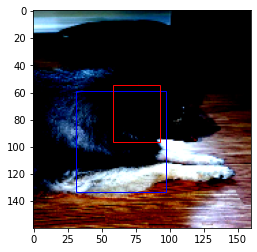

egyptian_mau
6
bengal


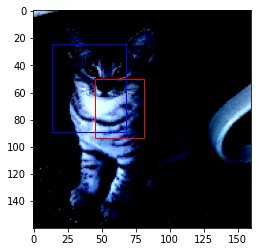

chihuahua
3
miniature_pinscher


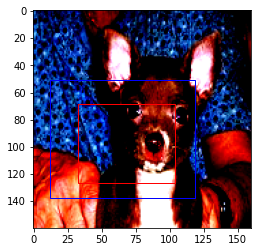

egyptian_mau
6
bengal


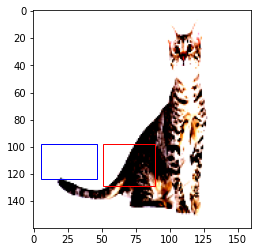

great_pyrenees
18
shiba_inu


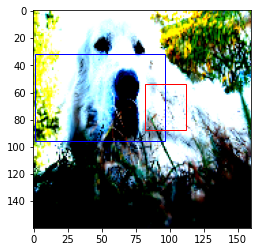

egyptian_mau
6
egyptian_mau


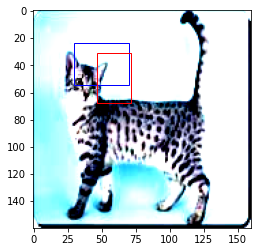

boxer
1
miniature_pinscher


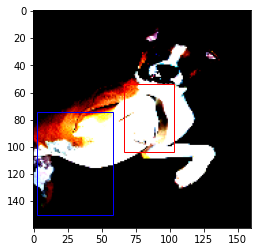

ragdoll
32
ragdoll


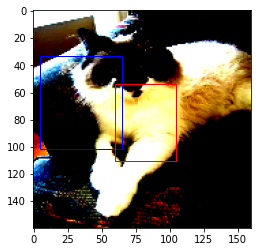

persian
0
persian


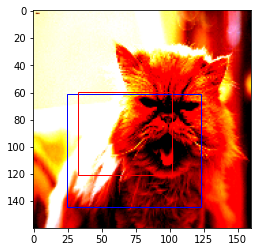

In [ ]:
# 4.
### YOUR CODE HERE
pred_bbox, pred_classes = model.predict(images)

images = np.clip(images,0,1)


for i in range(9):
	# get coordinates
  y1, x1, y2, x2 = labels[i][0], labels[i][1], labels[i][2], labels[i][3]

  y1_pred, x1_pred, y2_pred, x2_pred = pred_bbox[i][0], pred_bbox[i][1],pred_bbox[i][2],pred_bbox[i][3]
	# calculate width and height of the box
  width, height = x2 - x1, y2 - y1

  width_pred, height_pred = x2_pred - x1_pred, y2_pred - y1_pred
	# create the shape
  rect = Rectangle((x1, y1), width, height, fill=False, color='blue')

  rect_pred = Rectangle((x1_pred, y1_pred), width_pred, height_pred, fill=False, color='red')
	# draw the box
  pyplot.imshow(images[i])
  ax = pyplot.gca()

  

  print(classes[int(labels[i][4])])
  print(int(labels[i][4]))
  b = pred_classes.argmax(axis=-1)
  print(classes[b[i]])
  ax.add_patch(rect)
  ax.add_patch(rect_pred)
  pyplot.show()


